Loading MNIST dataset via Keras...
Dataset loaded successfully via Keras!
Training set: (60000, 784)
Test set: (10000, 784)
Sample labels: [5 0 4 1 9 2 1 3 1 4]


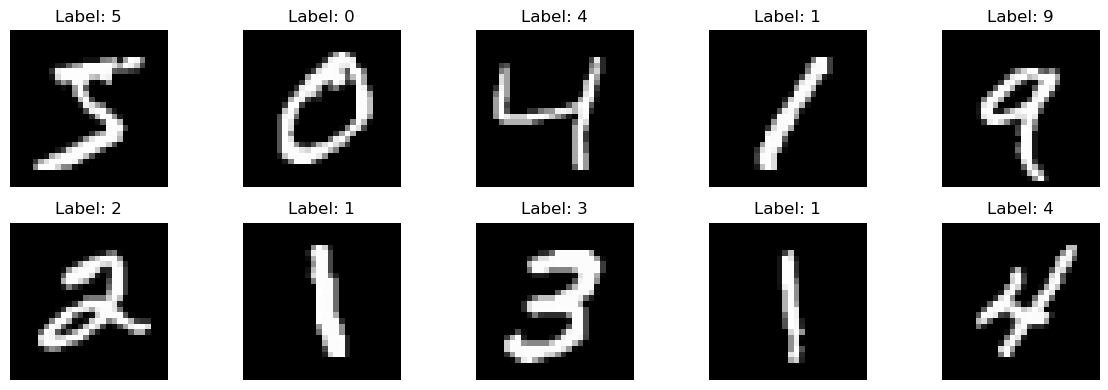

In [19]:
import numpy as np
import matplotlib.pyplot as plt

print("Loading MNIST dataset via Keras...")

from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Dataset loaded successfully via Keras!")



X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Sample labels: {y_train[:10]}")


plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
val_size = 10000
X_val = X_train[:val_size]
y_val = y_train[:val_size]
X_train = X_train[val_size:]
y_train = y_train[val_size:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(np.float32)

def softmax(x):

    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

print("Data preparation completed!")

Training set: 50000 samples
Validation set: 10000 samples
Test set: 10000 samples
Data preparation completed!


In [21]:
def cross_entropy_loss(y_pred, y_true):
    """Кросс-энтропия с one-hot кодированием"""
    m = y_true.shape[0]
    y_true_one_hot = np.zeros_like(y_pred)
    y_true_one_hot[np.arange(m), y_true] = 1


    loss = -np.sum(y_true_one_hot * np.log(y_pred + 1e-8)) / m
    return loss

def cross_entropy_derivative(y_pred, y_true):
    """Производная кросс-энтропии для softmax"""
    m = y_true.shape[0]
    y_true_one_hot = np.zeros_like(y_pred)
    y_true_one_hot[np.arange(m), y_true] = 1
    return (y_pred - y_true_one_hot) / m

print("Loss functions defined!")

Loss functions defined!


In [22]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros((1, output_size))

        self.learning_rate = learning_rate

    def forward(self, X):
        """Прямой проход"""
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = softmax(self.z2)

        return self.a2

    def backward(self, X, y, output):
        """Обратный проход"""
        m = X.shape[0]


        dz2 = cross_entropy_derivative(output, y)
        dW2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)


        dz1 = np.dot(dz2, self.W2.T) * relu_derivative(self.a1)
        dW1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def predict(self, X):
        """Предсказание"""
        output = self.forward(X)
        return np.argmax(output, axis=1)

    def accuracy(self, X, y):
        """Вычисление точности"""
        predictions = self.predict(X)
        return np.mean(predictions == y)

print("Neural Network class defined!")

Neural Network class defined!


In [23]:
def train_network(network, X_train, y_train, X_val, y_val, epochs=10, batch_size=128):
    """Обучение нейронной сети"""
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    n_batches = len(X_train) // batch_size

    print("Starting training...")

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0


        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        for i in range(n_batches):

            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]


            output = network.forward(X_batch)


            loss = cross_entropy_loss(output, y_batch)
            accuracy = network.accuracy(X_batch, y_batch)


            network.backward(X_batch, y_batch, output)

            epoch_loss += loss
            epoch_accuracy += accuracy

        avg_loss = epoch_loss / n_batches
        avg_accuracy = epoch_accuracy / n_batches
        val_accuracy = network.accuracy(X_val, y_val)

        train_losses.append(avg_loss)
        train_accuracies.append(avg_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Loss: {avg_loss:.4f}')
        print(f'  Train Accuracy: {avg_accuracy:.4f}')
        print(f'  Val Accuracy: {val_accuracy:.4f}')


        if epoch == 0 or epoch == epochs-1:
            print(f'  Debug - W1 mean: {np.mean(network.W1):.6f}')
            print(f'  Debug - Output range: [{np.min(output):.6f}, {np.max(output):.6f}]')

        print('-' * 50)

    return train_losses, train_accuracies, val_accuracies

print("Training function defined!")

Training function defined!


In [24]:

input_size = 784
hidden_size = 128
output_size = 10

nn = SimpleNeuralNetwork(input_size, hidden_size, output_size, learning_rate=0.1)

print("Neural Network created!")
print(f"Architecture: {input_size} -> {hidden_size} -> {output_size}")
print(f"Learning rate: {nn.learning_rate}")

initial_accuracy = nn.accuracy(X_val, y_val)
print(f"Initial validation accuracy: {initial_accuracy:.4f}")

train_losses, train_accuracies, val_accuracies = train_network(
    nn, X_train, y_train, X_val, y_val, epochs=15, batch_size=128
)

Neural Network created!
Architecture: 784 -> 128 -> 10
Learning rate: 0.1
Initial validation accuracy: 0.1072
Starting training...
Epoch 1/15:
  Loss: 0.5149
  Train Accuracy: 0.8554
  Val Accuracy: 0.9127
  Debug - W1 mean: 0.001848
  Debug - Output range: [0.000000, 0.999976]
--------------------------------------------------
Epoch 2/15:
  Loss: 0.2864
  Train Accuracy: 0.9178
  Val Accuracy: 0.9286
--------------------------------------------------
Epoch 3/15:
  Loss: 0.2365
  Train Accuracy: 0.9329
  Val Accuracy: 0.9375
--------------------------------------------------
Epoch 4/15:
  Loss: 0.2030
  Train Accuracy: 0.9433
  Val Accuracy: 0.9434
--------------------------------------------------
Epoch 5/15:
  Loss: 0.1778
  Train Accuracy: 0.9499
  Val Accuracy: 0.9479
--------------------------------------------------
Epoch 6/15:
  Loss: 0.1585
  Train Accuracy: 0.9558
  Val Accuracy: 0.9524
--------------------------------------------------
Epoch 7/15:
  Loss: 0.1433
  Train Accur

In [31]:
test_accuracy = nn.accuracy(X_test, y_test)
print(f"\n{'='*60}")
print(f"FINAL TEST ACCURACY: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*60}")


initial_val_acc = val_accuracies[0]
final_val_acc = val_accuracies[-1]
improvement = final_val_acc - initial_val_acc

print(f"\nTraining Analysis:")
print(f"  Starting Val Accuracy: {initial_val_acc:.4f}")
print(f"  Final Val Accuracy: {final_val_acc:.4f}")
print(f"  Improvement: +{improvement:.4f}")


print(f"\nExample predictions (first 10 test samples):")
print("Predicted vs Actual:")
correct_count = 0
for i in range(10):
    prediction = nn.predict(X_test[i:i+1])[0]
    actual = y_test[i]
    correct = prediction == actual
    correct_count += correct
    symbol = '✓' if correct else '✗'
    print(f"  Sample {i:2d}: Predicted: {prediction}, Actual: {actual} {symbol}")

print(f"Example accuracy: {correct_count}/10 = {correct_count/10:.1%}")


print(f"\nTest set performance:")
print(f"  Total samples: {len(X_test)}")
print(f"  Correct predictions: {int(test_accuracy * len(X_test))}")
print(f"  Wrong predictions: {len(X_test) - int(test_accuracy * len(X_test))}")


FINAL TEST ACCURACY: 0.9691 (96.91%)

Training Analysis:
  Starting Val Accuracy: 0.9127
  Final Val Accuracy: 0.9677
  Improvement: +0.0550

Example predictions (first 10 test samples):
Predicted vs Actual:
  Sample  0: Predicted: 7, Actual: 7 ✓
  Sample  1: Predicted: 2, Actual: 2 ✓
  Sample  2: Predicted: 1, Actual: 1 ✓
  Sample  3: Predicted: 0, Actual: 0 ✓
  Sample  4: Predicted: 4, Actual: 4 ✓
  Sample  5: Predicted: 1, Actual: 1 ✓
  Sample  6: Predicted: 4, Actual: 4 ✓
  Sample  7: Predicted: 9, Actual: 9 ✓
  Sample  8: Predicted: 6, Actual: 5 ✗
  Sample  9: Predicted: 9, Actual: 9 ✓
Example accuracy: 9/10 = 90.0%

Test set performance:
  Total samples: 10000
  Correct predictions: 9691
  Wrong predictions: 309


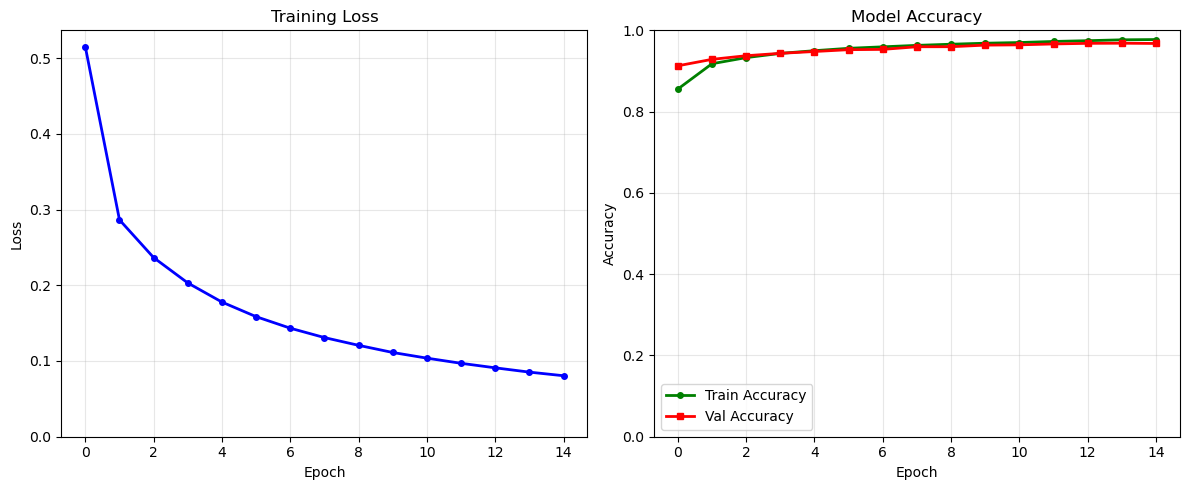


Training completed successfully!
Excellent results! Network is learning well.


In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', linewidth=2, marker='o', markersize=4)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'g-', label='Train Accuracy', linewidth=2, marker='o', markersize=4)
plt.plot(val_accuracies, 'r-', label='Val Accuracy', linewidth=2, marker='s', markersize=4)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print("\nTraining completed successfully!")

if test_accuracy > 0.85:
    print("Excellent results! Network is learning well.")
elif test_accuracy > 0.75:
    print("Good results! Network is learning.")
elif test_accuracy > 0.5:
    print("Moderate results. Consider tuning hyperparameters.")
else:
    print("Poor results. Check the implementation.")